In [1]:
import tensorflow as tf
import os
import pickle
import numpy as np

In [2]:
CIFAR_DIR = '/home/commaai-03/Data/dataset/cifar-10-python'

def unpickle(file):
    import pickle
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    return data

In [3]:
filenames = [os.path.join(CIFAR_DIR, file) 
             for file in os.listdir(CIFAR_DIR)
             if '.html' not in file]
filenames.sort()
meta_file = filenames[0]
train_files = filenames[1:-1]
test_file = [filenames[-1]]

In [4]:
_test_data = unpickle(test_file[0])
for k, v in _test_data.items():
    print(k)

b'batch_label'
b'labels'
b'data'
b'filenames'


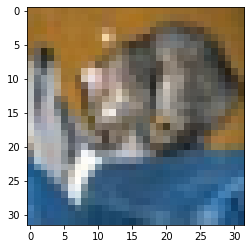

In [5]:
img_arr = _test_data[b'data'][0]
# 32 * 32 * 3 (R,G,B)
img_arr_reshaped = img_arr.reshape((3, 32, 32))
img = img_arr_reshaped.transpose(1, 2, 0)
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline
imshow(img)

In [6]:
class CifarData:
    
    def __init__(self, filenames, need_shuffle):
        all_data = []
        all_labels = []
        for filename in filenames:
            data, labels = self.load_data(filename)
            all_data.append(data)
            all_labels.append(labels)
        self._data = np.vstack(all_data)
        self._data = self._data / 127.5 - 1
        self._labels = np.hstack(all_labels)
        print('[CIFAR-10]: Data shape-> %s' % str(self._data.shape))
        print('[CIFAR-10]: Label shape-> %s' % str(self._labels.shape))
        
        self.num_examples = self._data.shape[0]
        self._need_shuffle = need_shuffle
        self._indicator = 0
        if self._need_shuffle:
            self._shuffle_data()
            
    def load_data(self, filename):
        import pickle
        with open(filename, mode='rb') as f:
            data = pickle.load(f, encoding='bytes')
        return data[b'data'], data[b'labels']
    
    def _shuffle_data(self):
        index = np.random.permutation(self.num_examples)
        self._data = self._data[index]
        self._labels = self._labels[index]
        
    def next_batch(self, batch_size):
        end_indicator = self._indicator + batch_size
        if end_indicator > self.num_examples:
            rest_num_examples = self.num_examples - self._indicator
            data_rest_part = self._data[self._indicator: self.num_examples]
            label_rest_part = self._labels[self._indicator: self.num_examples]
            
            if self._need_shuffle:
                self._shuffle_data()
            # For new loop, self._indicator + batch_size = self.num_examples
            self._indicator = batch_size - rest_num_examples
            end_indicator = self._indicator
            data_new_part = self._data[:end_indicator]
            label_new_part = self._labels[:end_indicator]
            batch_data = np.concatenate((data_rest_part, data_new_part), axis=0)
            batch_label = np.concatenate((label_rest_part, label_new_part), axis=0)
        else:
            batch_data = self._data[self._indicator:end_indicator]
            batch_label = self._labels[self._indicator:end_indicator]
            self._indicator = end_indicator
        
        return batch_data, batch_label

In [7]:
train_data = CifarData(train_files, need_shuffle=True)
test_data = CifarData(test_file, need_shuffle=False)

[CIFAR-10]: Data shape-> (50000, 3072)
[CIFAR-10]: Label shape-> (50000,)
[CIFAR-10]: Data shape-> (10000, 3072)
[CIFAR-10]: Label shape-> (10000,)


In [8]:
def inception_block(x, output_channel_for_path, name):
    '''
    Args:
    - x:
    - output_channel_for_path:
    - name:
    '''
    with tf.variable_scope(name):
        conv1_1 = tf.keras.layers.Conv2D(filters=output_channel_for_path[0], 
                                         kernel_size=(1,1), 
                                         strides=(1,1),
                                         padding='same', 
                                         activation=tf.nn.relu, name='conv1_1')(x)
        conv3_3 = tf.keras.layers.Conv2D(filters=output_channel_for_path[1], 
                                         kernel_size=(3,3), 
                                         strides=(1,1), 
                                         padding='same', 
                                         activation=tf.nn.relu, name='conv3_3')(x)
        conv5_5 = tf.keras.layers.Conv2D(filters=output_channel_for_path[2], 
                                         kernel_size=(5,5), 
                                         strides=(1,1), 
                                         padding='same', 
                                         activation=tf.nn.relu, name='conv5_5')(x)
        max_pooling = tf.keras.layers.MaxPooling2D(pool_size=(2,2), 
                                                   strides=(2,2), padding='valid')(x)
        
        max_pooling_shape = max_pooling.get_shape().as_list()[1:]
        input_shape = x.get_shape().as_list()[1:]
        width_padding = (input_shape[0] - max_pooling_shape[0]) // 2
        height_padding = (input_shape[1] - max_pooling_shape[1]) // 2
        padded_pooling = tf.pad(tensor=max_pooling,
                                paddings=[[0, 0], 
                                          [width_padding, width_padding],
                                          [height_padding, height_padding],
                                          [0, 0]])
        concat_layer = tf.concat(
            [conv1_1, conv3_3, conv5_5, padded_pooling], axis=3)
        return concat_layer

In [9]:
x = tf.placeholder(tf.float32, [None, 3072])
y = tf.placeholder(tf.int64, [None])

x_img = tf.reshape(x, [-1, 3, 32, 32])
# x_img shape: (32, 32, 3)
x_img = tf.transpose(x_img, perm=[0, 2, 3, 1])
# conv1 shape: (32, 32, 32) N = (M - K + 2P)/S + 1 32 = (32 - 3 + 2*1)/1 + 1
conv1 = tf.keras.layers.Conv2D(filters=32, 
                               kernel_size=(3, 3),
                               padding='same',
                               activation=tf.nn.relu, name='conv1')(x_img)
# pooling1 shape: (16, 16, 32)
pooling1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), 
                                        strides=(2,2), name='pool1')(conv1)
# inception_2a shape: (16, 16, 80) 80-> conv 16*3 + pooling 32
inception_2a = inception_block(pooling1, [16,16,16], name='inception_2a')
# inception_2b shape: (16, 16, 128)
inception_2b = inception_block(inception_2a, [16,16,16], name='inception_2b')
# pooling2 shape: (8, 8, 128)
pooling2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), 
                                        strides=(2,2), name='pool2')(inception_2b)
# inception_3a shape: (8, 8, 176)
inception_3a = inception_block(pooling2, [16,16,16], name='inception_3a')
# inception_3b shape: (8, 8, 224)
inception_3b = inception_block(inception_3a, [16,16,16], name='inception_3b')
# pooling3 shape: (4, 4, 224)
pooling3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), 
                                        strides=(2,2), name='pool3')(inception_3b)
# flatten shape: (3584,)
flatten = tf.keras.layers.Flatten()(pooling3)
y_ = tf.keras.layers.Dense(10)(flatten)

_loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)
predict = tf.argmax(y_, 1)
correct_prediction = tf.equal(predict, y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float64))

with tf.name_scope('train_op'):
    train_op = tf.train.AdamOptimizer(1e-3).minimize(_loss)

W0923 17:22:02.337958 140682904262464 deprecation.py:506] From /home/commaai-03/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0923 17:22:02.534355 140682904262464 deprecation.py:323] From /home/commaai-03/.local/lib/python3.6/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
init = tf.global_variables_initializer()
batch_size = 20
train_steps = 100000
test_steps = 2000

with tf.Session() as sess:
    sess.run(init)
    for i in range(train_steps):
        batch_data, batch_labels = train_data.next_batch(batch_size)
        loss, acc, _ = sess.run([_loss, accuracy, train_op], 
                                feed_dict={x: batch_data, y: batch_labels})
        
        if (i+1) % 100 == 0:
            print('[Train]: Step: %d, loss: %4.5f acc: %4.5f' 
                  % (i+1, loss, acc))
        if (i+1) % 1000 == 0:
            all_test_acc_val = []
            for j in range(test_steps):
                test_batch_data, test_batch_labels = test_data.next_batch(batch_size)
                test_acc_val = sess.run([accuracy], 
                                        feed_dict={x: test_batch_data, y: test_batch_labels})
                all_test_acc_val.append(test_acc_val)
            test_acc = np.mean(all_test_acc_val)
            print('[Test] Step: %d, acc: %4.5f' % (i+1, test_acc))

[Train]: Step: 100, loss: 2.00103 acc: 0.25000
[Train]: Step: 200, loss: 1.63289 acc: 0.35000
[Train]: Step: 300, loss: 1.46568 acc: 0.40000
[Train]: Step: 400, loss: 1.64273 acc: 0.40000
[Train]: Step: 500, loss: 1.44105 acc: 0.45000
[Train]: Step: 600, loss: 1.00346 acc: 0.75000
[Train]: Step: 700, loss: 1.22880 acc: 0.75000
[Train]: Step: 800, loss: 1.17306 acc: 0.65000
[Train]: Step: 900, loss: 1.35835 acc: 0.55000
[Train]: Step: 1000, loss: 1.37415 acc: 0.50000
[Test] Step: 1000, acc: 0.53780
[Train]: Step: 1100, loss: 1.29680 acc: 0.60000
[Train]: Step: 1200, loss: 1.47732 acc: 0.45000
[Train]: Step: 1300, loss: 1.38279 acc: 0.50000
[Train]: Step: 1400, loss: 1.37641 acc: 0.45000
[Train]: Step: 1500, loss: 1.01902 acc: 0.70000
[Train]: Step: 1600, loss: 0.90187 acc: 0.70000
[Train]: Step: 1700, loss: 1.07030 acc: 0.65000
[Train]: Step: 1800, loss: 0.76410 acc: 0.80000
[Train]: Step: 1900, loss: 1.22728 acc: 0.65000
[Train]: Step: 2000, loss: 1.08240 acc: 0.55000
[Test] Step: 2000

[Test] Step: 16000, acc: 0.75420
[Train]: Step: 16100, loss: 0.40674 acc: 0.85000
[Train]: Step: 16200, loss: 0.69450 acc: 0.65000
[Train]: Step: 16300, loss: 0.30918 acc: 0.95000
[Train]: Step: 16400, loss: 0.47537 acc: 0.80000
[Train]: Step: 16500, loss: 0.34696 acc: 0.80000
[Train]: Step: 16600, loss: 0.44248 acc: 0.80000
[Train]: Step: 16700, loss: 0.22396 acc: 0.90000
[Train]: Step: 16800, loss: 0.40117 acc: 0.85000
[Train]: Step: 16900, loss: 0.24629 acc: 0.90000
[Train]: Step: 17000, loss: 0.14469 acc: 1.00000
[Test] Step: 17000, acc: 0.73700
[Train]: Step: 17100, loss: 0.90757 acc: 0.70000
[Train]: Step: 17200, loss: 0.23079 acc: 0.90000
[Train]: Step: 17300, loss: 0.25886 acc: 0.90000
[Train]: Step: 17400, loss: 0.54199 acc: 0.90000
[Train]: Step: 17500, loss: 0.25524 acc: 0.95000
[Train]: Step: 17600, loss: 0.15908 acc: 0.95000
[Train]: Step: 17700, loss: 0.20836 acc: 0.90000
[Train]: Step: 17800, loss: 0.68433 acc: 0.80000
[Train]: Step: 17900, loss: 0.42008 acc: 0.80000
[Tr

[Train]: Step: 31800, loss: 0.22414 acc: 0.90000
[Train]: Step: 31900, loss: 0.05385 acc: 1.00000
[Train]: Step: 32000, loss: 0.14478 acc: 0.90000
[Test] Step: 32000, acc: 0.73860
[Train]: Step: 32100, loss: 0.15327 acc: 0.95000
[Train]: Step: 32200, loss: 0.59146 acc: 0.85000
[Train]: Step: 32300, loss: 0.43395 acc: 0.80000
[Train]: Step: 32400, loss: 0.15155 acc: 0.95000
[Train]: Step: 32500, loss: 0.24064 acc: 0.90000
[Train]: Step: 32600, loss: 0.03208 acc: 1.00000
[Train]: Step: 32700, loss: 0.33091 acc: 0.85000
[Train]: Step: 32800, loss: 0.09481 acc: 0.95000
[Train]: Step: 32900, loss: 0.29586 acc: 0.85000
[Train]: Step: 33000, loss: 0.02085 acc: 1.00000
[Test] Step: 33000, acc: 0.75390
[Train]: Step: 33100, loss: 0.05426 acc: 0.95000
[Train]: Step: 33200, loss: 0.03196 acc: 1.00000
[Train]: Step: 33300, loss: 0.28516 acc: 0.90000
[Train]: Step: 33400, loss: 0.27448 acc: 0.95000
[Train]: Step: 33500, loss: 0.23626 acc: 0.90000
[Train]: Step: 33600, loss: 0.18000 acc: 0.95000
[Tr

[Train]: Step: 47500, loss: 0.97310 acc: 0.85000
[Train]: Step: 47600, loss: 0.11344 acc: 0.90000
[Train]: Step: 47700, loss: 0.26020 acc: 0.90000
[Train]: Step: 47800, loss: 0.14138 acc: 0.95000
[Train]: Step: 47900, loss: 0.16294 acc: 0.95000
[Train]: Step: 48000, loss: 0.03038 acc: 1.00000
[Test] Step: 48000, acc: 0.74320
[Train]: Step: 48100, loss: 0.24302 acc: 0.90000
[Train]: Step: 48200, loss: 0.20752 acc: 0.90000
[Train]: Step: 48300, loss: 0.00375 acc: 1.00000
[Train]: Step: 48400, loss: 0.06774 acc: 1.00000
[Train]: Step: 48500, loss: 0.13347 acc: 0.95000
[Train]: Step: 48600, loss: 0.05387 acc: 1.00000
[Train]: Step: 48700, loss: 0.11546 acc: 0.95000
[Train]: Step: 48800, loss: 0.32343 acc: 0.95000
[Train]: Step: 48900, loss: 0.05266 acc: 1.00000
[Train]: Step: 49000, loss: 0.13650 acc: 0.90000
[Test] Step: 49000, acc: 0.74020
[Train]: Step: 49100, loss: 0.24465 acc: 0.85000
[Train]: Step: 49200, loss: 0.14347 acc: 0.95000
[Train]: Step: 49300, loss: 0.00727 acc: 1.00000
[Tr

[Train]: Step: 63200, loss: 0.10469 acc: 0.95000
[Train]: Step: 63300, loss: 0.00556 acc: 1.00000
[Train]: Step: 63400, loss: 0.17113 acc: 0.90000
[Train]: Step: 63500, loss: 0.15126 acc: 0.95000
[Train]: Step: 63600, loss: 0.04637 acc: 0.95000
[Train]: Step: 63700, loss: 0.01406 acc: 1.00000
[Train]: Step: 63800, loss: 0.00060 acc: 1.00000
[Train]: Step: 63900, loss: 0.21459 acc: 0.95000
[Train]: Step: 64000, loss: 0.32493 acc: 0.95000
[Test] Step: 64000, acc: 0.73190
[Train]: Step: 64100, loss: 0.06951 acc: 0.95000
[Train]: Step: 64200, loss: 0.05182 acc: 0.95000
[Train]: Step: 64300, loss: 0.00055 acc: 1.00000
[Train]: Step: 64400, loss: 0.01372 acc: 1.00000
[Train]: Step: 64500, loss: 0.07308 acc: 0.95000
[Train]: Step: 64600, loss: 0.09286 acc: 0.95000
[Train]: Step: 64700, loss: 0.13575 acc: 0.90000
[Train]: Step: 64800, loss: 0.04376 acc: 0.95000
[Train]: Step: 64900, loss: 0.00543 acc: 1.00000
[Train]: Step: 65000, loss: 0.03476 acc: 1.00000
[Test] Step: 65000, acc: 0.73910
[Tr

[Train]: Step: 79000, loss: 0.04575 acc: 0.95000
[Test] Step: 79000, acc: 0.72720
[Train]: Step: 79100, loss: 0.19977 acc: 0.90000
[Train]: Step: 79200, loss: 0.03022 acc: 1.00000
[Train]: Step: 79300, loss: 0.00012 acc: 1.00000
[Train]: Step: 79400, loss: 0.01084 acc: 1.00000
[Train]: Step: 79500, loss: 0.00914 acc: 1.00000
[Train]: Step: 79600, loss: 0.47037 acc: 0.90000
[Train]: Step: 79700, loss: 0.00545 acc: 1.00000
[Train]: Step: 79800, loss: 0.11369 acc: 0.95000
[Train]: Step: 79900, loss: 0.19971 acc: 0.90000
[Train]: Step: 80000, loss: 0.00766 acc: 1.00000
[Test] Step: 80000, acc: 0.73370
[Train]: Step: 80100, loss: 0.00348 acc: 1.00000
[Train]: Step: 80200, loss: 0.31459 acc: 0.90000
[Train]: Step: 80300, loss: 0.00487 acc: 1.00000
[Train]: Step: 80400, loss: 0.00457 acc: 1.00000
[Train]: Step: 80500, loss: 0.00105 acc: 1.00000
[Train]: Step: 80600, loss: 0.52407 acc: 0.95000
[Train]: Step: 80700, loss: 0.23573 acc: 0.90000
[Train]: Step: 80800, loss: 0.00357 acc: 1.00000
[Tr

[Train]: Step: 94700, loss: 0.38994 acc: 0.90000
[Train]: Step: 94800, loss: 0.12283 acc: 0.95000
[Train]: Step: 94900, loss: 0.00320 acc: 1.00000
[Train]: Step: 95000, loss: 0.00432 acc: 1.00000
[Test] Step: 95000, acc: 0.73480
[Train]: Step: 95100, loss: 0.06446 acc: 0.95000
[Train]: Step: 95200, loss: 0.00693 acc: 1.00000
[Train]: Step: 95300, loss: 0.08701 acc: 0.95000
[Train]: Step: 95400, loss: 0.08516 acc: 0.95000
[Train]: Step: 95500, loss: 0.05606 acc: 0.95000
[Train]: Step: 95600, loss: 0.81537 acc: 0.90000
[Train]: Step: 95700, loss: 0.19392 acc: 0.90000
[Train]: Step: 95800, loss: 0.01501 acc: 1.00000
[Train]: Step: 95900, loss: 0.05183 acc: 0.95000
[Train]: Step: 96000, loss: 0.13477 acc: 0.95000
[Test] Step: 96000, acc: 0.73560
[Train]: Step: 96100, loss: 0.00002 acc: 1.00000
[Train]: Step: 96200, loss: 0.36526 acc: 0.90000
[Train]: Step: 96300, loss: 0.00528 acc: 1.00000
[Train]: Step: 96400, loss: 0.20971 acc: 0.90000
[Train]: Step: 96500, loss: 0.02321 acc: 1.00000
[Tr

KeyboardInterrupt: 